# DSCI478 Kaggle Project - Credit Card Fraud Detection
### Nick Brady, Jakob Wickham

Note for us:
- If you want the PDF to not display a cell, click the three dots on the cell, click "Add Cell Tag", and put "remove_cell"
- If you want to hide the code instead, put "remove_input"

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [50]:
df = pd.read_csv("combined_data.csv")

In [51]:
df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0
...,...,...,...,...,...,...,...,...,...
1754150,1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,0
1754151,1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,0
1754152,1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,0
1754153,1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,0


# Introduction

In 2024 alone, 134 million Americans have been victims of credit card fraud, with unauthorized purchases accounting for 6.2 billion dollars annually. This trend of fraud is on the rise in financial and business challenges. (Reference 1).  While consumers are generally protected from fraudulent transactions, the impact is beyond the negative experience; financial institutions and businesses bear the cost.

To reduce these risks, financial institutions leverage Machine Learning (ML) and other statistical models to detect and prevent transactions from occurring. Creating effective fraud detection models has challenges, including correctly classifying fraudulent transactions, minimizing customer impact with false positives, and dealing with multiple fraud vectors.

In this project, we will explore the process of creating a fraud detection model, the data set we used, feature engineering, model evaluation metrics, and the challenges of imbalanced data sets. Since fraudulent activity is rare, accuracy metrics are not applicable when determining model evaluation as they mainly give a score on how well it detects *non-fraud*. In this project we will be using precision, recall, F1 score and the Precision-Recall Curve (PR - AUC) to provide an accurate representation of the model given the challenges in the data set.

## The Dataset

Due to the nature of the information for credit card purchases, we used a synthetic data set (References 2 & 3), which allows us to explore fraud detection techniques while also maintaining privacy and security concerns. Below is a list of the features.

\begin{table}[h]
    \centering
    \begin{tabular}{| l | p{10cm} |}
        \hline
        \textbf{Feature} & \textbf{Description} \\
        \hline
        TRANSACTION\_ID & A unique identifier for the transaction \\
        \hline
        TX\_DATETIME & Date and time at which the transaction occurs \\
        \hline
        CUSTOMER\_ID & The identifier for the customer. Each customer has a unique identifier \\
        \hline
        TERMINAL\_ID & The identifier for the merchant (or, more precisely, the terminal). Each terminal has a unique identifier \\
        \hline
        TX\_AMOUNT & The amount of the transaction \\
        \hline
        TX\_FRAUD & A binary variable with the value for a legitimate transaction or the value for a fraudulent transaction \\
        \hline
        TX\_TIME\_SECONDS & Timestamp of transaction in seconds \\
        \hline
        TX\_TIME\_DAYS & Timestamp of transaction in days \\
        \hline
        TX\_FRAUD\_SCENARIO & Numerical indicator of the type of fraud scenario \\
        \hline
    \end{tabular}
    \caption{Transaction Features and Their Descriptions}
    \label{tab:transaction_features}
\end{table}

This synthetic data can help us in research and model experimentation. It introduces limitations: the data may not reflect real world approaches that fraudsters use, customer transactions may lack variability, and `TX_FRAUD_SCENARIO` can create potential data leakage.
With those limitations in mind, we want to be able to focus on building feature engineering and methods that can generalize well to actual scenarios. We must first explore the data cleaning and processing steps taken to prepare the data set for modeling.

# Data Cleaning and Preprocessing

Before conducting exploratory data analysis and model development, we had to clean data and process the data.

Since this data was synthetically generated, no missing (NaN) values were present. In the data, the `TX_FRAUD_SCENARIO` column was dropped to prevent data leakage as it contained information directly to the fraud classification. `TX_DATETIME` was transformed into multiple features--`TX_HOUR` (hour of the transaction) and `TX_DAYOFWEEK` (day of the transaction week)--to capture temporal patterns. Once that transformation was completed, `TX_DATETIME` was dropped due to redundant data.

Completing these preprocessing steps ensure that the dataset was structured for feature extraction while also minimizing data leakage. Transforming `TX_DATETIME` allowed us to capture temporal fraud patterns. With these preprocessing steps done, the data set is now ready for exploratory data analysis (EDA), where we will be determining patterns in fraudulent and non-fraudulent transactions, key trends and assess potential predictive features.

In [52]:
# Load and Preprocess Data

df.columns = df.columns.str.strip().str.upper()

# Drop unnecessary column
df.drop(columns=['TX_FRAUD_SCENARIO'], inplace=True)

# Convert TX_DATETIME and extract key time features
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])
df['TX_HOUR'] = df['TX_DATETIME'].dt.hour
df['TX_DAYOFWEEK'] = df['TX_DATETIME'].dt.dayofweek
df.drop(columns=['TX_DATETIME'], inplace=True)


# Time-Based Split
split_point = df['TX_TIME_DAYS'].quantile(0.8)
train_df = df[df['TX_TIME_DAYS'] < split_point].copy()
test_df = df[df['TX_TIME_DAYS'] >= split_point].copy()

# Exploratory Data Analysis

Initially we performed basic data exploration to learn more about our data set. One of the first things in our exploration analysis that was noticeable was that the data set was highly imbalanced, with only fraudulent activity making up a small proportion of the total (which was a given considering we're working with fraud). Being aware of class balance is important as it affects model performance and evaluation metrics. Additionally, we analyzed the average transaction that customers typically make with their cards. With this information we wanted to determine if going above or below the average transaction was more likely fraudulent. Since this was a significant factor in fraud detection, we further explored whether a customer’s personal average carried more of a determining factor than global average (See Figure 1).

In [53]:
# Calculate the average non-fraud transaction amount for each customer
customer_avg_amount = df.groupby(['CUSTOMER_ID'])['TX_AMOUNT'].mean().reset_index()

# Calculate the average fraud transaction amount for each customer
customer_avg_fraud_amount = df[df['TX_FRAUD'] == 1].groupby(['CUSTOMER_ID'])['TX_AMOUNT'].mean().reset_index()

customer_avg_merged = pd.merge(customer_avg_amount, customer_avg_fraud_amount, how='inner', suffixes=('_nonfraud', '_fraud'), on='CUSTOMER_ID').fillna(0)

customer_avg_merged["ABOVE_AVG"] = customer_avg_merged["TX_AMOUNT_fraud"] > customer_avg_merged["TX_AMOUNT_nonfraud"]
customer_avg_merged["BELOW_AVG"] = ~customer_avg_merged["ABOVE_AVG"]

count_above = len(customer_avg_merged[customer_avg_merged["ABOVE_AVG"]])
count_below = len(customer_avg_merged[customer_avg_merged["BELOW_AVG"]])
percentage_above = len(customer_avg_merged[customer_avg_merged["ABOVE_AVG"]]) / len(customer_avg_merged)
percentage_below = len(customer_avg_merged[customer_avg_merged["BELOW_AVG"]]) / len(customer_avg_merged)

summary_table = pd.DataFrame({
    'Metric': ['Fraud Above Personal Average', 'Fraud Not Above Personal Average'],
    'Count': [count_above, count_below],
    'Percentage': [f"{percentage_above:.2f}%", f"{percentage_below:.2f}%"]
})

print(summary_table)

                             Metric  Count Percentage
0      Fraud Above Personal Average   2169      0.62%
1  Fraud Not Above Personal Average   1303      0.38%


Our findings showed that incorporating a customer’s historical spending behavior improved the chance of finding fraudulent activity, which could show that people who commit fraud are trying to stay within the expected spending patterns of the individual.

We also investigated whether certain terminals were consistent with fraudulent activity (See Figure 2).

In [54]:
fraud_df = df[df['TX_FRAUD'] == 1]

# Extract unique fraud in the data
fraud_dates_sorted = fraud_df[["TERMINAL_ID", "TX_TIME_DAYS"]].drop_duplicates().sort_values(["TERMINAL_ID", "TX_TIME_DAYS"])

# Calculate day differences between consecutive fraud events per terminal
fraud_dates_sorted["PREV_DAY"] = fraud_dates_sorted.groupby("TERMINAL_ID")["TX_TIME_DAYS"].shift(1)
fraud_dates_sorted["DAY_DIFF"] = fraud_dates_sorted["TX_TIME_DAYS"] - fraud_dates_sorted["PREV_DAY"]

diffs = fraud_dates_sorted.dropna(subset=["DAY_DIFF"])

# Create a table to display the information
terminal_gap_summary = diffs.groupby("TERMINAL_ID").agg(
    total_gaps=("DAY_DIFF", "count"),
    consecutive_gaps=("DAY_DIFF", lambda x: (x == 1).sum())
).reset_index()

# Compute additional statistics
terminal_gap_summary["gap_ratio"] = terminal_gap_summary["consecutive_gaps"] / terminal_gap_summary["total_gaps"]
terminal_gap_summary["non_consecutive_gaps"] = terminal_gap_summary["total_gaps"] - terminal_gap_summary["consecutive_gaps"]

# Classify fraud patterns
terminal_gap_summary["fraud_pattern"] = terminal_gap_summary["gap_ratio"].apply(
    lambda r: "Consecutive" if r >= 0.5 else "Non-Consecutive"
)

# Count fraud
fraud_counts = fraud_df.groupby("TERMINAL_ID").size().reset_index(name="fraud_count")

# Merge tables
merged_summary = pd.merge(terminal_gap_summary, fraud_counts, on="TERMINAL_ID", how="left")

# Compute summary statistics by fraud pattern
pattern_summary = merged_summary.groupby("fraud_pattern").agg(
    Terminal_Count=("TERMINAL_ID", "count"),
    Fraud_Count=("fraud_count", "sum"),
).reset_index()

# Compute additional statistics
pattern_summary["Terminal_Percentage"] = pattern_summary["Terminal_Count"] / pattern_summary["Terminal_Count"].sum() * 100
pattern_summary["Fraud_Percentage"] = pattern_summary["Fraud_Count"] / pattern_summary["Fraud_Count"].sum() * 100

pattern_summary = pattern_summary.round(2)

print(pattern_summary.set_index("fraud_pattern").transpose())

fraud_pattern        Consecutive  Non-Consecutive
Terminal_Count            323.00          1139.00
Fraud_Count              7831.00          4030.00
Terminal_Percentage        22.09            77.91
Fraud_Percentage           66.02            33.98


This revealed that a small number of terminals were responsible for a large portion of fraud, often occurring over consecutive days. However, there was no fixed pattern in the number of days fraud occurred and no clear distinction between whether a certain day should be a concern (See Figure 3).

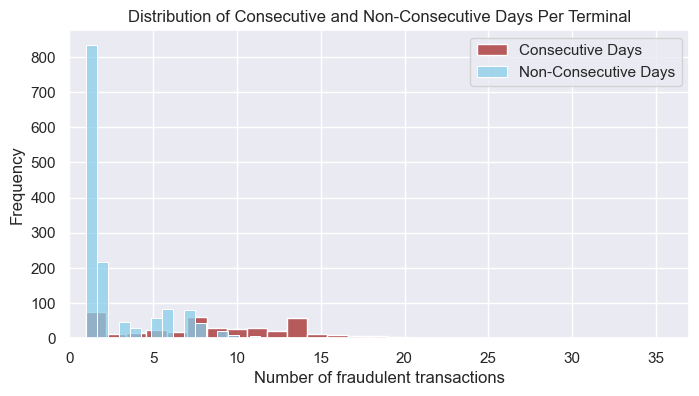

In [55]:
_, ax = plt.subplots(1, 1, figsize=(8,4))

consecutive_counts = diffs[diffs["DAY_DIFF"] == 1]["TERMINAL_ID"].value_counts()
non_consecutive_counts = diffs[diffs["DAY_DIFF"] > 1]["TERMINAL_ID"].value_counts()

sns.set_theme(style="darkgrid")
sns.histplot(x=consecutive_counts, bins=30, kde=False, ax=ax, color="brown")
sns.histplot(x=non_consecutive_counts, bins=20, kde=False, ax=ax, color='skyblue')
ax.set_xlim([0, max(consecutive_counts.max(), non_consecutive_counts.max())])
ax.set(xlabel = "Number of fraudulent transactions", ylabel="Frequency",
       title="Distribution of Consecutive and Non-Consecutive Days Per Terminal")
ax.legend(["Consecutive Days", "Non-Consecutive Days"]);

To address this, we had to implement a way in our classification approach that acknowledges that past fraudulent activity at a terminal is a strong factor, but not all future transactions at that terminal should be flagged as fraud.

Our exploration analysis showed many key significant insights into fraud detection, which include class imbalance, transaction amount and terminal level indicators. Those findings gave us information that was necessary to implement our feature engineering and modeling approach to account for the customer and terminal behavior patterns and minimize our bias in our model.

# Feature Engineering

To create a robust fraud detection, we engineered features that capture both population fraud trends and individual customer-based spending behaviors. This creates a model that can detect a wide range of fraud tactics while also identifying personalized anomalies that could indicate fraudulent activity at a customer level.

Transaction amount serves as a critical indication in fraudulent activity, so we'd want to try and capture this. We applied a Z-score normalization to standardize transactions relative to the dataset mean, which ensures that large transaction values were flagged as unusual. However, some of the fraudulent activities attempted to fall within the customer expected ranges but still would appear abnormal compared to overall transaction patterns. Since specific terminals were exploited, we implemented rolling seven-and twenty-eight day rolling fraud rates. Acknowledging that a terminal who has had fraudulent activity doesn’t mean they will always be fraudulent we implemented an exponential decay factor to ensure old occurrences of fraud had a diminishing influence in our model and attempting to prevent model but still capturing consistent fraud risk. To further improve our population fraud trend, we implemented a Local Outlier Factor (LOF), which is an unsupervised anomaly detection method that assigned a likelihood of fraud score based on its behavior. This method creates context-based detecting and maintains to not solely rely on extreme transaction values. During the feature engineering process we considered using an Isolation Forest for our unsupervised choice, but the anomaly score made our model rely on the Isolation Forest prediction, which reduced its ability to learn other fraudulent trends.

Listed below shows all population-based features that were created.

\begin{table}[h]
    \centering
    \begin{tabular}{| l | p{10cm} |}
        \hline
        \textbf{Feature} & \textbf{Purpose} \\
        \hline
        TX\_AMOUNT\_Z\_Score & Check for extreme transaction amounts compared to data set's mean \\
        \hline
        TX\_AMOUNT\_Percentile & Check transaction amounts relative to all others \\
        \hline
        TERMINAL\_FRAUD\_RATIO & Terminal-level fraud check that decays over time \\
        \hline
        ANOMALY\_SCORE (LOF) & Unsupervised learning to apply a score beyond deviation of previous features \\
        \hline
    \end{tabular}
    \caption{Feature Description and Purpose}
    \label{tab:feature_purpose}
\end{table}

The population-based trend provides a big picture view of our sample, but fraudulent transactions often are different from customer to customer rather than the population itself. To recognize this, we engineered features that will adapt to each customer's unique spending habits instead of over relying on dataset wide fraud indicators. The key feature of detecting fraud at a customer level is track spending behavior over time. We computed a 14-day rolling window that tracks whether a customer suddenly makes a significant change in their spending habits. This can help with identifying fraud scenarios where fraudsters make large transactions over a short period, deviation from previous spending habits. We normalized the transaction amount based on each customer's historical data instead of the entire data set. This implementation prevents the model from flagging frequently high spending larger transactions, while still detecting unexpected large purchases from lower spending customers.

The table below shows all customer-based features that were created.

\begin{table}[h]
    \centering
    \begin{tabular}{| l | p{10cm} |}
        \hline
        \textbf{Customer-Based Features} & \textbf{Purpose} \\
        \hline
        SPENDING\_RATIO\_CHANGE & Checks for sudden shifts in customer spending behavior \\
        \hline
        SPENDING\_Z\_SCORE\_28D & Identifies how unusual a transaction is for a specific customer based on their historical spending patterns \\
        \hline
    \end{tabular}
    \caption{Customer-Based Features and Their Purpose}
    \label{tab:customer_features}
\end{table}

By looking at both the population and customer-based fraud detection the purpose is to create a model that can identify fraud trends that are occurring at large scale, but also adapting to customer-level behavior. This combination with dynamic adjusting and personalized profiles attempts to create a fraud detection model that is both effective and adaptable at identifying ever changing fraud tactics.
With the creation of these engineered features, we now will focus on model selection and evaluating different approaches at models to classify fraudulent activity effectively

In [56]:
# Feature Engineering Rolling Windows with decay
scaler = StandardScaler()
train_df['TX_AMOUNT_Z_SCORE'] = scaler.fit_transform(train_df[['TX_AMOUNT']])
test_df['TX_AMOUNT_Z_SCORE'] = scaler.transform(test_df[['TX_AMOUNT']])

train_df['TX_AMOUNT_PERCENTILE'] = train_df['TX_AMOUNT'].rank(pct=True)
test_df['TX_AMOUNT_PERCENTILE'] = test_df['TX_AMOUNT'].rank(pct=True)

# Optimize Decay Factor 
decay_values = np.linspace(0.8, 0.99, 20)  
best_decay, best_corr = 0.95, float('-inf')  

for decay in decay_values:
    temp_df = train_df.copy()
    temp_df['TERMINAL_FRAUD_RATIO_28D'] = (
        temp_df.groupby('TERMINAL_ID')['TX_FRAUD']
        .shift(1)
        .ewm(alpha=1-decay)
        .mean()
    )
    correlation = temp_df['TERMINAL_FRAUD_RATIO_28D'].corr(temp_df['TX_FRAUD'])
    
    if correlation > best_corr:
        best_corr = correlation
        best_decay = decay

optimal_decay = best_decay  # Best decay factor based on correlation

# Apply the optimized decay factor
train_df['TERMINAL_FRAUD_RATIO_28D'] = (
    train_df.groupby('TERMINAL_ID')['TX_FRAUD']
    .shift(1)
    .ewm(alpha=1-optimal_decay)
    .mean()
)
test_df['TERMINAL_FRAUD_RATIO_28D'] = (
    test_df.groupby('TERMINAL_ID')['TX_FRAUD']
    .shift(1)
    .ewm(alpha=1-optimal_decay)
    .mean()
)

# Terminal Fraud Ratios
train_df['TERMINAL_FRAUD_RATIO_7D'] = (
    train_df.groupby('TERMINAL_ID')['TX_FRAUD']
    .shift(1)
    .rolling(7, min_periods=1)
    .mean()
)
test_df['TERMINAL_FRAUD_RATIO_7D'] = (
    test_df.groupby('TERMINAL_ID')['TX_FRAUD']
    .shift(1)
    .rolling(7, min_periods=1)
    .mean()
)

# Customer Spending Trends
train_df['SPENDING_RATIO_CHANGE'] = (
    train_df.groupby('CUSTOMER_ID')['TX_AMOUNT']
    .transform(lambda x: x.pct_change().rolling(14, min_periods=1).mean())
)
test_df['SPENDING_RATIO_CHANGE'] = (
    test_df.groupby('CUSTOMER_ID')['TX_AMOUNT']
    .transform(lambda x: x.pct_change().rolling(14, min_periods=1).mean())
)

train_df['SPENDING_Z_SCORE_28D'] = (
    train_df.groupby('CUSTOMER_ID')['TX_AMOUNT']
    .transform(lambda x: (x - x.mean()) / (x.std() + 1))
)
test_df['SPENDING_Z_SCORE_28D'] = (
    test_df.groupby('CUSTOMER_ID')['TX_AMOUNT']
    .transform(lambda x: (x - x.mean()) / (x.std() + 1))
)


# Anomaly Detection (Local Outlier Factor)
features_for_lof = ['TX_AMOUNT_Z_SCORE', 'SPENDING_RATIO_CHANGE', 'TERMINAL_FRAUD_RATIO_28D']
train_df[features_for_lof] = train_df[features_for_lof].fillna(train_df[features_for_lof].median())
test_df[features_for_lof] = test_df[features_for_lof].fillna(test_df[features_for_lof].median())

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.005, novelty=True)
lof.fit(train_df[features_for_lof].values)

train_df['ANOMALY_SCORE'] = lof.decision_function(train_df[features_for_lof].values)
test_df['ANOMALY_SCORE'] = lof.decision_function(test_df[features_for_lof].values)

# Normalize Anomaly Scores
scaler = MinMaxScaler()
train_df['ANOMALY_SCORE'] = scaler.fit_transform(train_df[['ANOMALY_SCORE']])
test_df['ANOMALY_SCORE'] = scaler.transform(test_df[['ANOMALY_SCORE']])

In [57]:
engineered_features = ['TX_AMOUNT_Z_SCORE',
                       'TX_AMOUNT_PERCENTILE',
                       'TERMINAL_FRAUD_RATIO_7D',
                       'TERMINAL_FRAUD_RATIO_28D',
                       'SPENDING_RATIO_CHANGE',
                       'SPENDING_Z_SCORE_28D',
                       'ANOMALY_SCORE']

for feature in engineered_features:
    median_value = train_df[feature].median()
    train_df[feature] = train_df[feature].fillna(median_value)
    test_df[feature] = test_df[feature].fillna(median_value)

# Model Selection

Dealing with the data imbalance is a fundamental challenge in the data set; classifiers would predict the majority class, which is not the main factor that we are trying to classify. To address this, we selected a combination of models that will vary based on interpretability and accuracy: **Balanced Random Forest (BRF)**, **XGBoost**, and a **stacked model**. We also selected a **Logistic Regression** model to see how a simple model would perform too.

With each of these models, we used a Local Outlier Factor (LOF), which is an unsupervised anomaly detection model that was implemented in our feature engineering. LOFs generate an anomaly score based on its nearest neighbors in terms of the objective, and give a score based on how significantly different the transactions were compared to the others which assisted the models in classifying fraud.

We chose to use BRFs because it would be the most interpretable model to understand how the fraud is detected. It handles imbalanced data well due to the undersampling of the majority class at each tree, but can miss complex fraud patterns with non-linear relationships.
XGBoost was chosen because it can handle complex non linear relationships and with scale_pos_weight it can handle imbalances through class weighting, but it relies on gradient boosting which makes individual decisions less clear compared to BRF (Reference 4).
Our last model was stacking, which combines both previous models together; It combines the strength and weakness of both models together into a meta-model to combine both of those previous inputs together. Due to the meta-model, the final decisions are not directly interpretable (Reference 5).

With the choice of our model made, designed to handle the class imbalance, we need to run each model and evaluate each to choose which model would be best for our objective. 

# Model Training and Evaluation

We will be using 4 scores to determine how well our models perform: Precision, Recall, F1, and a PR-AUC score.

- Precision (PPV): Correctly identified fraudulent cases across all *classified* fraudulent cases
    - Also called the "positive predictive value"
- Recall (TPR): Correctly identified fraudulent cases across all *truly* fraudulent cases
    - Also called the "true positive rate", power, or sensitivity
- F1: A metric providing a balanced measure of the harmonic mean of precision and recall
- PR-AUC: The model's ability to distinguish between classes (Reference 6)

F1 Score will be the main determining factor, to determine how well our models perform, because it considers both *predicting* and *detecting* a fraudulent case. Both cases can be costly and give us a better real-world measure of fraud detection. A higher F1-Score means the model is better at balancing precision and recall, which is critical to fraud detection and other imbalanced classification problems
We have omitted accuracy from consideration because it is misleading with extreme class imbalances, in our data set only 0.84% of all transaction were fraudulent. Since it makes such a small percentage of all transaction, and predicts the *majority* class (legitimate transactions), which is not the objective of our models.


In [58]:
def model_run(model: BalancedRandomForestClassifier | XGBClassifier | StackingClassifier,
              features = engineered_features, train_df = train_df, test_df = test_df) -> dict[str, float]:
    # Train the model
    model.fit(train_df[features], train_df['TX_FRAUD'])
    
    # Predictions
    y_pred = model.predict(test_df[features])
    y_scores = model.predict_proba(test_df[features])[:,1]

    precision = precision_score(test_df['TX_FRAUD'], y_pred)
    recall = recall_score(test_df['TX_FRAUD'], y_pred)
    f1 = f1_score(test_df['TX_FRAUD'], y_pred)
    pr_auc = average_precision_score(test_df['TX_FRAUD'], y_scores)
    
    tn, fp, fn, tp = confusion_matrix(test_df['TX_FRAUD'], y_pred).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    return {
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'PR-AUC': pr_auc,
        'FPR': fpr
    }

In [59]:
logreg_model = LogisticRegression()

logreg_results = model_run(logreg_model)

In [60]:
brf_model = BalancedRandomForestClassifier(n_estimators=500, max_depth=15, random_state=42, class_weight='balanced_subsample')

brf_results = model_run(brf_model)

In [61]:
# Make weights
neg_count = train_df['TX_FRAUD'].value_counts()[0]
pos_count = train_df['TX_FRAUD'].value_counts()[1]
scale_pos_weight = neg_count / pos_count

# Run XGBoost
xgb_model: XGBClassifier = XGBClassifier()
xgb_model.objective = 'binary:logistic'
xgb_model.scale_pos_weight = scale_pos_weight

xgb_results = model_run(xgb_model)

In [62]:
meta_model = LogisticRegression()

stacking_model = StackingClassifier(
    estimators=[
        ('brf', brf_model),
        ('xgb', xgb_model)
    ],
    final_estimator=meta_model,
    passthrough=True
)

stacking_results = model_run(stacking_model)

                    Model  Precision    Recall        F1    PR-AUC
0     Logistic Regression   0.640849  0.351590  0.454065  0.569117
1  Balanced Random Forest   0.307768  0.890463  0.457434  0.685667
2                 XGBoost   0.355417  0.861190  0.503172  0.586850
3                Stacking   0.656351  0.700976  0.677930  0.652004


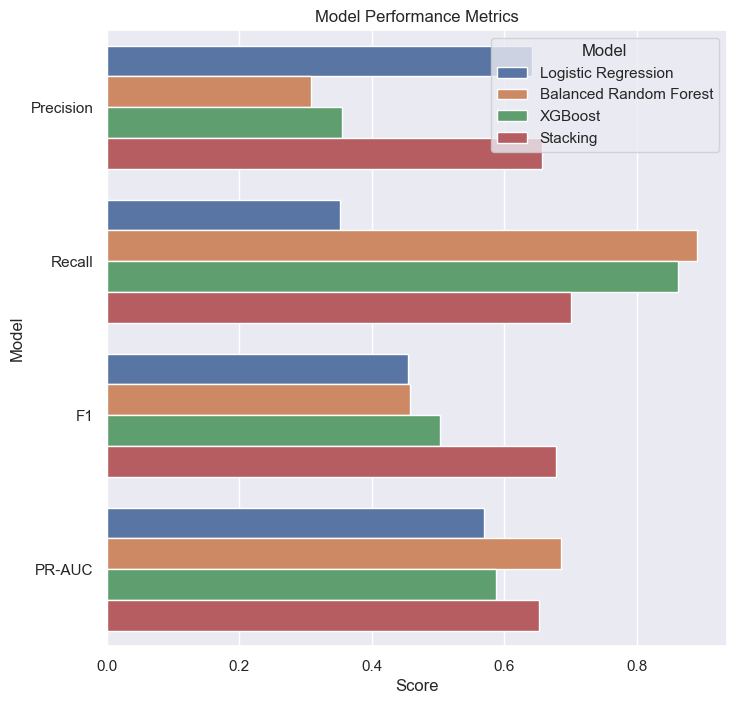

In [63]:
# Merge all model results into one dataframe
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Balanced Random Forest', 'XGBoost', 'Stacking'],
    'Precision': [logreg_results['Precision'], brf_results['Precision'], xgb_results['Precision'], stacking_results['Precision']],
    'Recall': [logreg_results['Recall'], brf_results['Recall'], xgb_results['Recall'], stacking_results['Recall']],
    'F1': [logreg_results['F1'], brf_results['F1'], xgb_results['F1'], stacking_results['F1']],
    'PR-AUC': [logreg_results['PR-AUC'], brf_results['PR-AUC'], xgb_results['PR-AUC'], stacking_results['PR-AUC']],
})

print(results_df)

results_df_melt = pd.melt(results_df, id_vars=['Model'], value_vars=['Precision', 'Recall', 'F1', 'PR-AUC'], var_name='Metric', value_name='Score')

_, ax = plt.subplots(figsize=(8, 8))
sns.set_theme(style="darkgrid")

sns.barplot(y="Metric", x="Score", hue="Model", ax=ax, data=results_df_melt)
ax.set(ylabel = "Model", xlabel="Score",
       title="Model Performance Metrics");

Each of these models have their own unique strengths and weaknesses, and the “best” choice is dependent on real-world scenarios.
- If minimizing false positives are critical, avoiding legitimate transactions being blocked and creating a negative customer experience, and precision model is preferred
- If prioritizing capturing as many fraudulent cases as possible is the priority even at the risk of false positives, a recall model is recommended 

From our evaluations, charts and graphs show, the stacking model is shown to have the best tradeoff between precision and recall. Likely due to the meta-model leveraging both BRF’s recall and Boosts precision, leading to more optimized classification. BRF did have the highest recall, it suffers in poor precision, making its F1 score slightly better than our logistic model.
By combining the strength of multiple models stacking is shown to have the highest F1-score, which is a balanced approach to fraud classification while minimizing our FPR. Being aware of your business needs is critical cause missing both missing fraud and misclassifying transactions carry significant risks. 


# Model Interpretation and Explainability

After our model evaluation we investigated our feature importances to see if there were any similarities between the Balanced Random Forest and XGBoost models.

In [ ]:
df2 = pd.concat([train_df, test_df], axis=0)

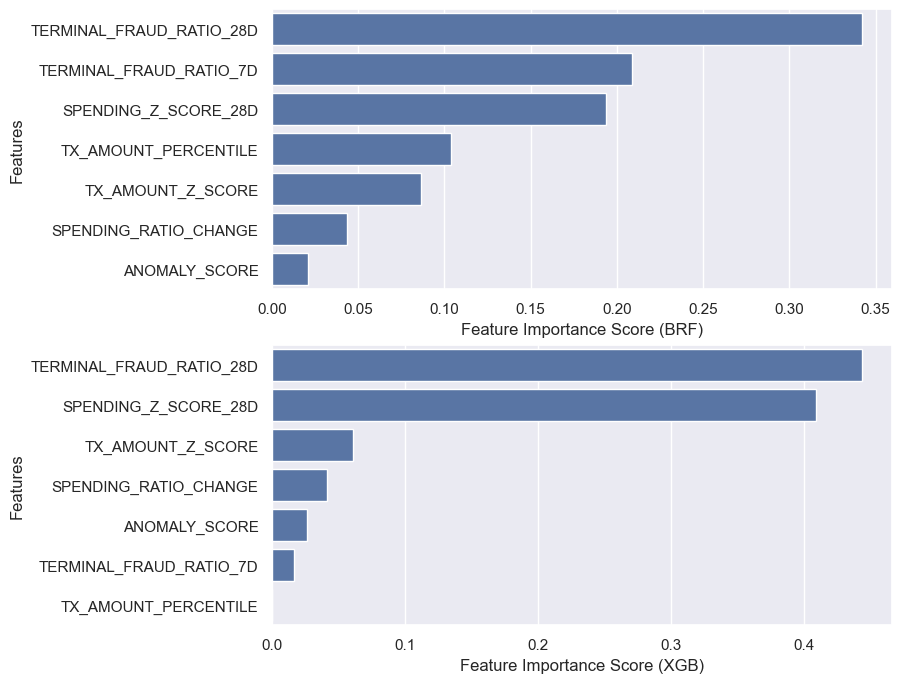

In [ ]:
_, ax = plt.subplots(2, 1, figsize=(8, 8))

brf_importances = pd.DataFrame({'Features': engineered_features, 'BRF': brf_model.feature_importances_})
xgb_importances = pd.DataFrame({'Features': engineered_features, 'XGB': xgb_model.feature_importances_})

sns.barplot(y="Features", x="BRF", ax=ax[0], data=brf_importances.sort_values(by="BRF", ascending=False))
ax[0].set(xlabel = "Feature Importance Score (BRF)", ylabel="Features")
sns.barplot(y="Features", x="XGB", ax=ax[1], data=xgb_importances.sort_values(by="XGB", ascending=False))
ax[1].set(xlabel = "Feature Importance Score (XGB)", ylabel="Features");

Both models shown that `TERMINAL_FRAUD_RATIO_28D`as the most important feature, indicating that historical fraudulent active over a 28-day rolling period plays a significant role in fraud detection. Additionally, `SPENDING_Z_SCORE_28D` ranked 3rd in BRF and 2nd in XGBoost suggesting that deviation in customer spending habits also contributes to fraud classification. To better understand why these features were important to our model with visualized their distribution to explain their predictive power. Since `TERMINAL_FRAUD_RATIO_28D` already provides a longer outlook, we decided to only at this one instead of the TERMINAL_FRAUD_RATIO_7D

### Upon examination of `TERMINAL_FRAUD_RATIO_28D`:

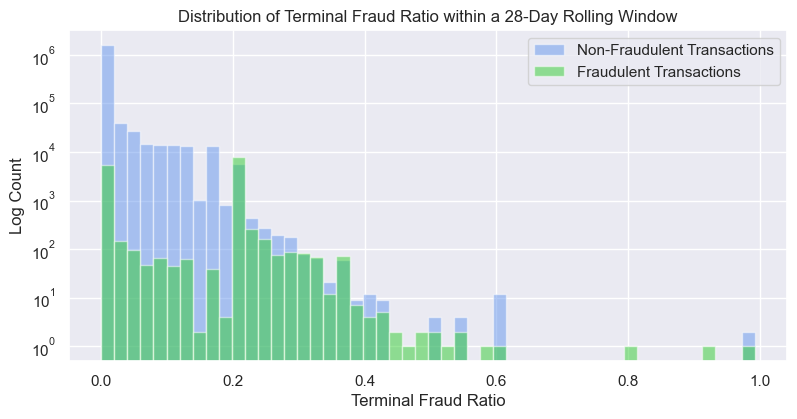

In [ ]:
terminal_fraud_ratio_28d_nonfraud = pd.DataFrame(df2[df2['TX_FRAUD'] == 0]["TERMINAL_FRAUD_RATIO_28D"])
terminal_fraud_ratio_28d_fraud = pd.DataFrame(df2[df2['TX_FRAUD'] == 1]["TERMINAL_FRAUD_RATIO_28D"])

_, ax = plt.subplots(1, 1, figsize=(8, 4))
_.tight_layout(h_pad=4)

terminal_fraud_ratio_28d_nonfraud.plot(kind='hist', ax=ax, bins=50, logy=True, color='cornflowerblue', alpha=0.5)
terminal_fraud_ratio_28d_fraud.plot(kind='hist', ax=ax, bins=50, logy=True, color='limegreen', alpha=0.5)

ax.set(xlabel = "Terminal Fraud Ratio", ylabel="Log Count",
          title="Distribution of Terminal Fraud Ratio within a 28-Day Rolling Window");
ax.legend(["Non-Fraudulent Transactions", "Fraudulent Transactions"]);

The distribution of fraud within a 28 day rolling windows confirms why`TERMINAL_FRAUD_RATIO_28D`is the most important feature in our detection model. From the graph Fraudulent transaction cluster when the fraud ration is above 0.2. Which reinforces our idea that past fraud activity at the terminal is a predictor of future fraudulent occurrences. 
However, the graph shows that fraud still occurs at terminals with low historical fraud trend, which means in our model we cannot solely be reliant on this feature because it will miss fraud on terminal with no previous occurrences at it. Which emphasizes our need for customer-level features such as `SPENDING_Z_SCORE_28D. 
The logarithmic scale shows the extreme class imbalances in our problem, with our legitimate transaction outnumbering the fraudulent cases, which shows the importance of the precision-recall trade during our model evaluation. This specific feature is a powerful tool to predict our objective but it need to be combined with our customer specific metrics to improve our detection and reduce false positives. 

### Upon examination of `SPENDING_Z_SCORE_28D`:

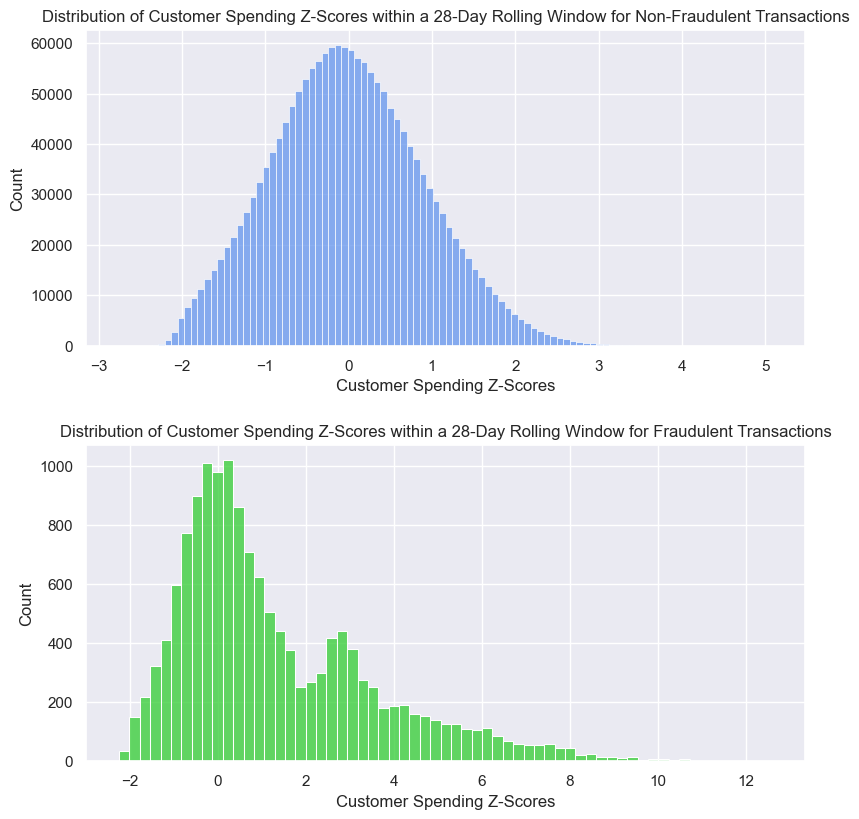

In [ ]:
_, ax = plt.subplots(2, 1, figsize=(8, 8))
_.tight_layout(h_pad=4)
sns.set_theme(style="darkgrid")

sns.histplot(data=df2[df2['TX_FRAUD'] == 0], x='SPENDING_Z_SCORE_28D', ax=ax[0], bins=100, color='cornflowerblue')
ax[0].set(xlabel = "Customer Spending Z-Scores", ylabel="Count",
          title="Distribution of Customer Spending Z-Scores within a 28-Day Rolling Window for Non-Fraudulent Transactions");
sns.histplot(data=df2[df2['TX_FRAUD'] == 1], x='SPENDING_Z_SCORE_28D', ax=ax[1], color='limegreen')
ax[1].set(xlabel = "Customer Spending Z-Scores", ylabel="Count",
          title="Distribution of Customer Spending Z-Scores within a 28-Day Rolling Window for Fraudulent Transactions");

`SPENDING_Z_SCORE_28D` provided valuable information on how customer spending behavior can impact classification. From non-fraudulent the distribution (Top Graph) is centered around 0, like a normal distribution, which suggests that most customers have predicable spending habits. In comparison fraudulent transactions have a peak of around 0 and display a wider range of values. Which shoes large deviation from the predictable spending habits of customer is a strong indicator of fraud. The difference in those distributions were made more distinct due to our feature engineering process which transformed the raw transaction data into actionable behavioral metrics which helps our model differentiate between the two classes more effectively. With incorporating both population-based features like `TERMINAL_FRAUD_RATIO_28D`and customer-based features, we improved our model’s ability to find trend that we are not obvious from the raw data alone. 
When creating fraud classification model, balancing the false positives (incorrectly flagging legitimate transactions) and false negatives (failing to detect fraud) is paramount. If it produces too many false positives, customers will experience unnecessary declines leading to customers leaving the financial institution. If we have too many transactions that are fraud and are still processed, it leads to financial loses to banks and merchants. Precision and Recall have an inverse relationship, improving one involves sacrificing the other. Due to our previous experiences with fraud and imbalanced data we went directly to more complex models like Balanced Random Forest (BRF) and XGBoost over simpler model like logistic regression. Logistic regression provides interpretability through feature coefficients, it assumes a linear relationship between features, which limits its ability to find complex trends in behavior. BRF and XGBoost can model non-linear relationships in the data and capture complex trends without making assumption about the underlying data at a cost of these model are now “Black Boxes” which makes their decision hard to interpret which poses regulatory and legal hurdles which justifying the fraud classification. 
We chose the model that achieved the best balance in both fraud detection and minimizing false positives and leveraging the strengths and weakness of multiple models. Depending on business fraud strategies, different models can be optimized to prioritize business needs. By applying feature engineering techniques, we created a way to make the difference between transactions distinct so our model could be able to differentiate between them, make it more efficient and reliable. 
In real world deployment, fraud detection models are more than what on paper the most optimized it must also align with business need and regulatory compliance. Future work could explore more options to tune fraud thresholds or add more adaptive techniques. In essence, fraud detection comes down to the continues observation of data and combating the ever-evolving fraud tactics and combating them with statistical model. 


# Conclusion

When fitting our models onto the feature-engineered dataset, we specifically chose the features from our exploratory data analysis that would have an impact on detecting fraud. However, there could possibly be other features we additional features that we did not incorporate such as CUSTOMER_ID based behavioral trends or temporal variations inTX_DATETIME, that could further improve our model. Given more time and computational power was a consideration, we didn’t focus on tuning any hyperparameters for our models. With each of these models being considered a base model, they performed better than expected, which showed the effectiveness of our feature engineering. If we had additional time and computational power, we could have used additional time to improve these models by adjusting hyperparameters to achieve a higher F1 score.

To test the importance of feature engineering, we ran our original data (without feature engineering) through a BRF model to evalue its performance. The results were significantly worse:

In [68]:
split_point = df['TX_TIME_DAYS'].quantile(0.8)
base_train_df = df[df['TX_TIME_DAYS'] < split_point].copy()
base_test_df = df[df['TX_TIME_DAYS'] >= split_point].copy()

# Extract features and target variable
base_features = ['CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_HOUR', 'TX_DAYOFWEEK']
target = 'TX_FRAUD'

X_train, y_train = base_train_df[base_features], base_train_df[target]
X_test, y_test = base_test_df[base_features], base_test_df[target]

# Initialize Balanced Random Forest
base_brf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

base_brf_results = model_run(base_brf_model, train_df = base_train_df, test_df = base_test_df, features = base_features)

pd.DataFrame({"Score": base_brf_results})

,Score
Precision,0.021450
Recall,0.427762
F1,0.040851
PR-AUC,0.237507
FPR,0.176401


With a precision rate of 0.02, recall rate of 0.43, and F1 score of 0.04, reinforcing the need for feature engineering. We made an assumption that the underlying nature of the data includes information that is not explained in the original dataset. 

For our chosen model, what decided to be the “best” we would, in this six-month time period the dataset spanned, have flagged roughly 5,820 incidents of fraud that are not and wouldn’t have caught roughly 4,390 fraudulent activities. Each of these causes monetary cost to the organization. Until further tuning, threshold adjusts, and real-world validation is conducted we would not recommend deploying these models in production environments, but this demonstrated a strong foundation in fraud classification and highlighting areas of improvement that can be made. 

# References

\raggedright
\begin{enumerate}
	\item \textbf{Credit Card Fraud Report:}
	\url{https://www.security.org/digital-safety/credit-card-fraud-report/}

	\item \textbf{Credit Card Fraud Detection Dataset (Kaggle):}
	\url{https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud}

	\item \textbf{Fraud Detection Handbook - Simulated Dataset:}
	\url{https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html}

	\item \textbf{XGBoost Explained - A Beginner’s Guide:}  
	\url{https://medium.com/low-code-for-advanced-data-science/xgboost-explained-a-beginners-guide-095464ad418f}

	\item \textbf{Combine Predictors Using Stacking:}
    \url{https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html}

	\item \textbf{Ultimate Guide to Precision-Recall AUC:}
	\url{https://www.aporia.com/learn/ultimate-guide-to-precision-recall-auc-understanding-calculating-using-pr-auc-in-ml/}
\end{enumerate}